<a href="https://colab.research.google.com/github/Mohamed-Harish-M-123/Capstone-Project-III/blob/main/Coronavirus_Tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Project Name: Coronavirus Tweets Sentiment Analysis**
####**Project Type:** Machine Learning - Classification
####**Contribution:** Individual
####**Name:** MOHAMED HARISH


##**GitHub Link:** https://github.com/Mohamed-Harish-M-123/Capstone-Project-III

## **Business context:**
####This challenge asks you to build a classification model to predict the sentiment of covid-19 tweets. The tweets have been pulled from Twitter and manual tagging has been done then. The names and usernames have been given codes to avoid any privacy concerns.

##**Problem statement:**
####In the context of analyzing COVID-19 tweets, the task is to develop a sentiment classification model that accurately predicts the sentiment expressed in these tweets. Manual tagging has been performed on the tweets to assign sentiment labels. However, due to the vast amount of data generated on social media platforms like Twitter, manual analysis becomes time-consuming and inefficient. Therefore, there is a need to automate the sentiment analysis process for COVID-19 tweets to provide timely insights and understand public sentiment during the pandemic.
####The challenge lies in building a robust and accurate classification model that can handle the nuances of the language used in these tweets, account for privacy concerns by encoding names and usernames, and effectively classify tweets into positive, negative, or neutral sentiment categories.
####The successful development of such a model will enable organizations to gain real-time insights into public sentiment regarding COVID-19, allowing them to make informed decisions and respond effectively to public concerns and needs.

##Importing libraries:

In [115]:
# Here we'll import the required libraries for this project

from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

!pip install contractions

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Now let's load our dataset in this notebook 

In [28]:
# Mount the drive and read the csv file which is our dataset
drive.mount("/content/drive")

path = "/content/drive/MyDrive/dataset/Coronavirus Tweets.csv"

df = pd.read_csv(path, encoding='latin-1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# View the dataset

df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive


In [30]:
# Check the info of our dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [31]:
# Checking null values

df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [32]:
# Check if any duplicates present

print("Duplicated records present in our dataset is ", df.duplicated().sum())

Duplicated records present in our dataset is  0


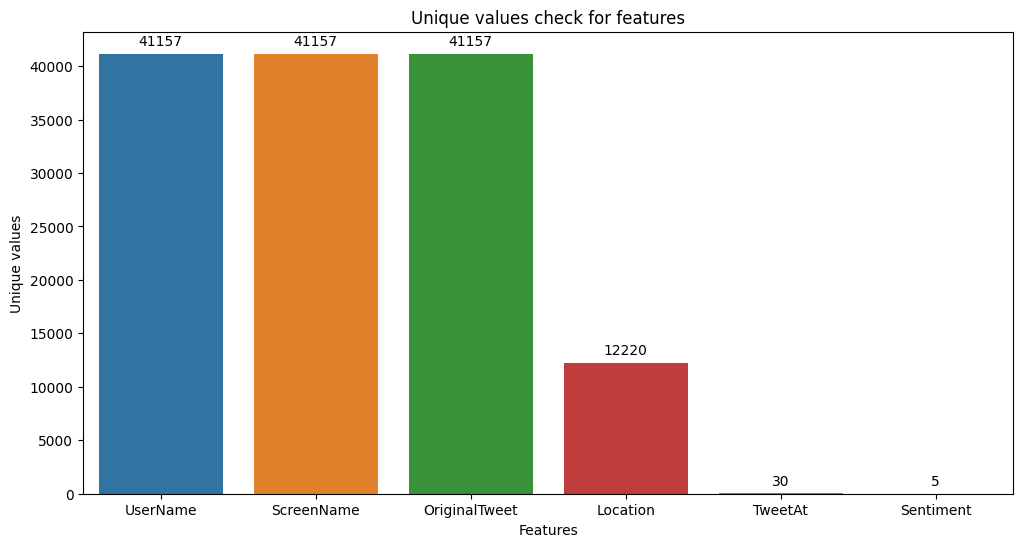

In [33]:
# Plot for checking the unique values in the features of our dataset

#Creating a empty dataframe and add a column called 'Features' having the column names of our dataset
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]

#Creating a another column called 'Uniques' and maintain the unique value counts in that.
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique
unique_df = unique_df.sort_values(by='Uniques', ascending=False)
f, ax = plt.subplots(1,1, figsize=(12,6))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'])
#Label the unique value count in the each and respective bars
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Unique values check for features')
plt.ylabel('Unique values')
plt.xlabel('Features')
plt.show()

###Dataset overview:
* Dataset has 6 features in total. 2 Numerical and 4 Categorical features.
* Column Location has 8590 null values.
* No duplicated records in the dataset.

## Let's start with the Exploratory Data Analysis (EDA)

In [34]:
# Before proceeding, lets take a copy of our original dataset for further processing.

tweets_df = df.copy()


In [35]:
# Change the 'TweetAt' column datatype from object to datatime datatype

tweets_df['TweetAt'] = pd.to_datetime(tweets_df['TweetAt'])
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


<ipython-input-35-b8e62f27c1f4>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  tweets_df['TweetAt'] = pd.to_datetime(tweets_df['TweetAt'])


In [36]:
# Extracting the day and month from the 'TweetAt' column

tweets_df['tweeted_day'] = tweets_df['TweetAt'].dt.day_name()
tweets_df['tweeted_month'] = tweets_df['TweetAt'].dt.month_name()

tweets_df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweeted_day,tweeted_month
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Monday,March
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,Monday,March
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,Monday,March


Text(0.5, 1.0, 'Most tweets - Location')

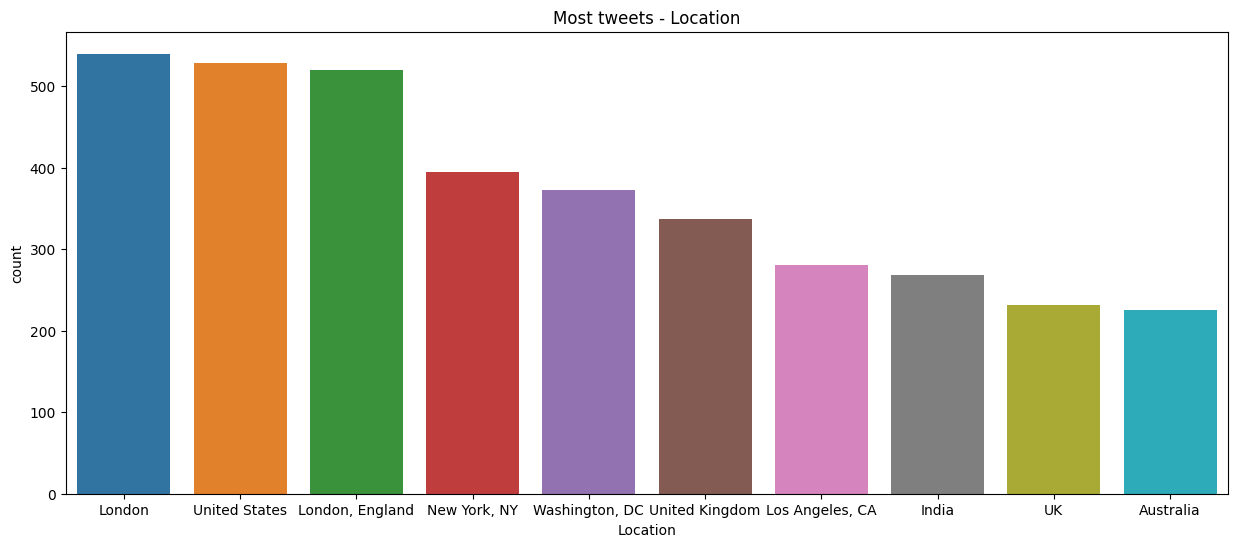

In [37]:
# Lets check the top 10 tweeted location in our dataset

top_tweeted_location = tweets_df['Location'].value_counts().sort_values(ascending=False)[:10]

# Visualize the above insight

plt.figure(figsize=(15,6))
sns.countplot(x='Location',data=tweets_df[tweets_df['Location'].isin(top_tweeted_location.index)],order=top_tweeted_location.index)
plt.title('Most tweets - Location')

Text(0.5, 1.0, 'Most tweets - Month')

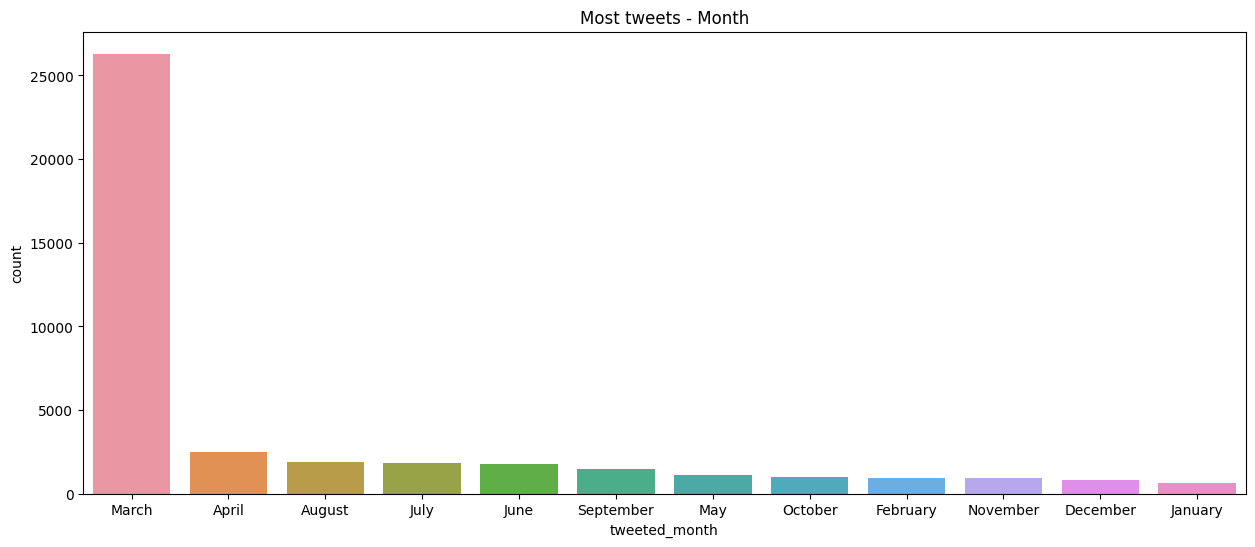

In [38]:
# Checking with the 'tweeted_month' column.

plt.figure(figsize=(15,6))
sns.countplot(data=tweets_df, x='tweeted_month', order=tweets_df['tweeted_month'].value_counts(ascending=False).index)
plt.title('Most tweets - Month')

Text(0.5, 1.0, 'Most tweets - Day')

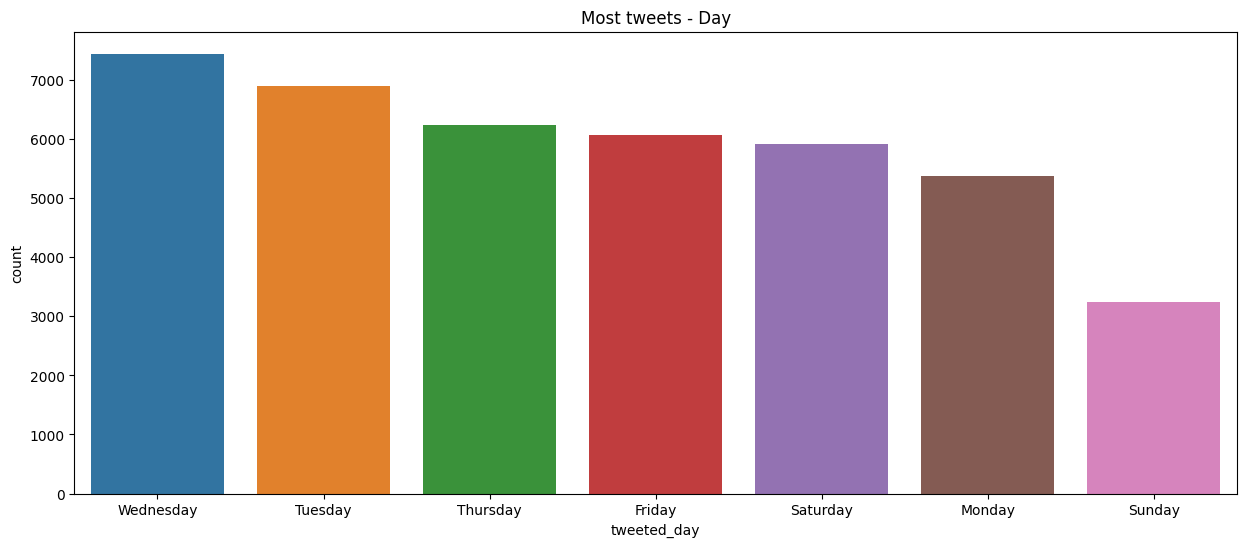

In [39]:
# Checking with the 'tweeted_day' column.

plt.figure(figsize=(15,6))
sns.countplot(data=tweets_df, x='tweeted_day', order=tweets_df['tweeted_day'].value_counts(ascending=False).index)
plt.title('Most tweets - Day')

In [40]:
tf = tweets_df['Sentiment'].value_counts()
tf

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

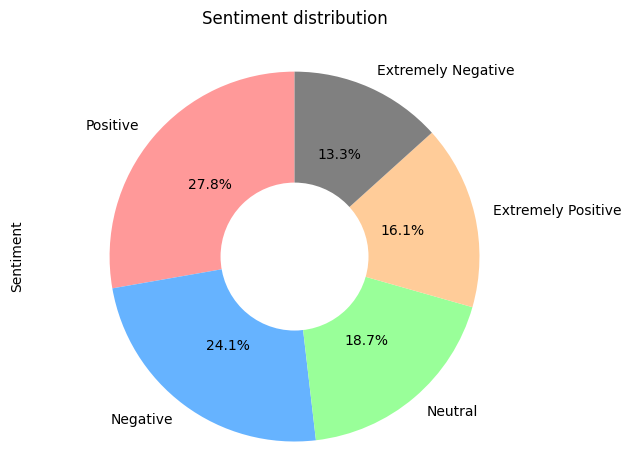

In [41]:
# Visualize the 'sentiment' column by donut chart 

fig,ax = plt.subplots()

# specify colurs in hex values 
colors1 = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#808080']

# Plot the pie
tweets_df['Sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%', colors = colors1 ,startangle=90)

#draw centre circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Sentiment distribution\n')  
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Tweet Response Timeline'}, xlabel='TweetAt'>

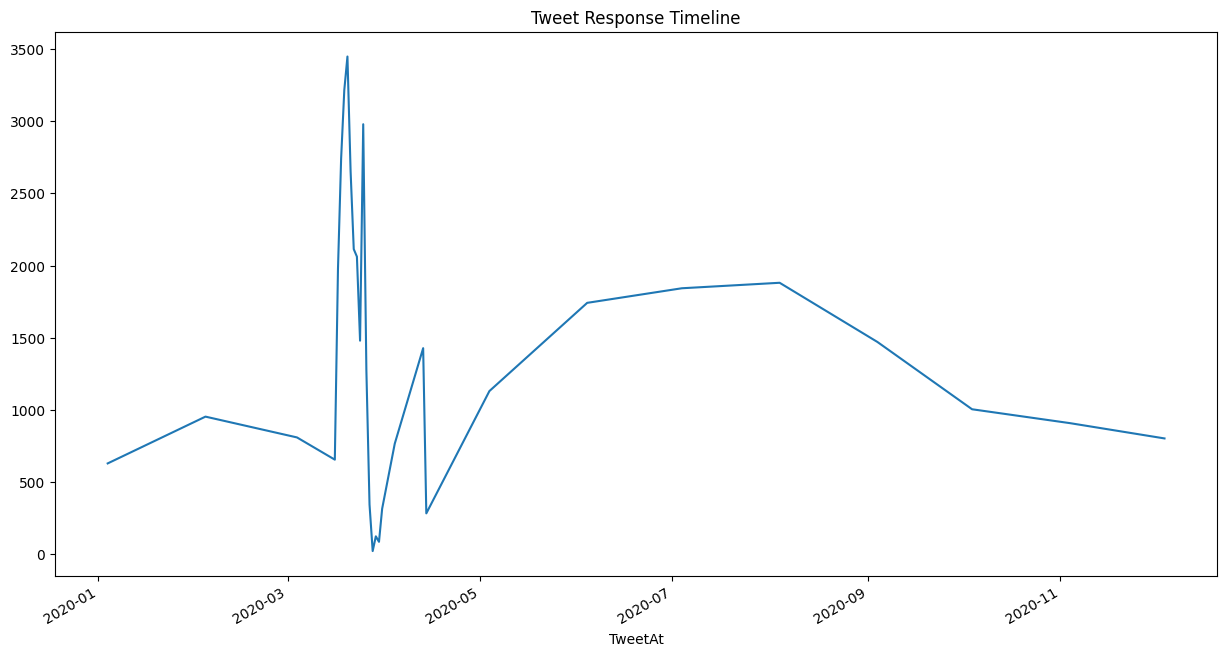

In [42]:
# Visualize the tweets timeline
plt.figure(figsize=(15,8))
tweet_timeline=tweets_df.groupby('TweetAt').count().sort_values(by='TweetAt')['OriginalTweet']
plt.title('Tweet Response Timeline')
tweet_timeline.plot()

## **Data cleaning and Handling null values**

In [43]:
# Check the null values in your dataset once
tweets_df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
tweeted_day         0
tweeted_month       0
dtype: int64

In [44]:
# Calculate the percentage of null values in each column
null_percentage = tweets_df['Location'].isnull().mean() * 100
print(f'Percentage of null values in "Location": {null_percentage:.2f}%')

Percentage of null values in "Location": 20.87%


In [45]:
# Replace the null value of Location column with 'Other location' 
tweets_df['Location'] = tweets_df['Location'].fillna('Other location')
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       41157 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
 6   tweeted_day    41157 non-null  object        
 7   tweeted_month  41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 2.5+ MB


###**Expand the contractions from the tweets**

In [46]:
# Import the contraction_dict
from contractions import contractions_dict

# Function to expand contractions
def expand_contractions(text):
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text

# Apply the expand_contractions function to the textual column
tweets_df['modifiedTweet'] = tweets_df['OriginalTweet'].apply(expand_contractions)
tweets_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweeted_day,tweeted_month,modifiedTweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Monday,March,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,Monday,March,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,Monday,March,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,Other location,2020-03-16,My food stock is not the only one which is emp...,Positive,Monday,March,My food stock is not the only one which is emp...
4,3803,48755,Other location,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Monday,March,"Me, ready to go at supermarket during the #COV..."


###**Remove punctuation for your modified tweets**

In [47]:
# Use regular expression to remove punctuations
# removes all non-alphanumeric characters and spaces
def remove_punctuations(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the remove_punctuations function to the textual column
tweets_df['modifiedTweet'] = tweets_df['modifiedTweet'].apply(remove_punctuations)
tweets_df.head(6)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweeted_day,tweeted_month,modifiedTweet
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Monday,March,MeNyrbie Phil_Gahan Chrisitv httpstcoiFz9FAn2P...
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,Monday,March,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,Monday,March,Coronavirus Australia Woolworths to give elder...
3,3802,48754,Other location,2020-03-16,My food stock is not the only one which is emp...,Positive,Monday,March,My food stock is not the only one which is emp...
4,3803,48755,Other location,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Monday,March,Me ready to go at supermarket during the COVID...
5,3804,48756,"ÃT: 36.319708,-82.363649",2020-03-16,As news of the regionÂs first confirmed COVID...,Positive,Monday,March,As news of the regionÂs first confirmed COVID1...


###**Remove URLs from the modified tweets**

In [48]:
# Removing the urls using the regex from the modified text feature
def remove_urls(text):
    # Use regular expression to remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    return text

tweets_df['modifiedTweet'] = tweets_df['modifiedTweet'].apply(remove_urls)

print(tweets_df['OriginalTweet'][0])
print(tweets_df['modifiedTweet'][0])

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
MeNyrbie Phil_Gahan Chrisitv  and  and 


###**Switch the modified tweets to lower case**

In [49]:
# Change to lower case
tweets_df['modifiedTweet'] = tweets_df['modifiedTweet'].str.lower()

###**Perform Tokenization**

In [50]:
# Make the words in tweets as tokens. 
import nltk
nltk.download('punkt')

def apply_tokenization(sentence):    
    words = word_tokenize(sentence)  # Instantiation of tokenizer
    return words

tweets_df['modifiedTweet'] = tweets_df['modifiedTweet'].apply(apply_tokenization)

print(tweets_df['OriginalTweet'][2])
print(tweets_df['modifiedTweet'][2])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
['coronavirus', 'australia', 'woolworths', 'to', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'covid19', 'outbreak']


###**Remove stop words from the modified tweets from our dataset**

In [51]:
# Download the stopwords corpus
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

tweets_df['modifiedTweet'] = tweets_df['modifiedTweet'].apply(remove_stopwords)

print(tweets_df['OriginalTweet'][0])
print(tweets_df['modifiedTweet'][0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
['menyrbie', 'phil_gahan', 'chrisitv']


###**Stemming or Lemmatization**

In [52]:
from nltk.stem import PorterStemmer

# Create an instance of the PorterStemmer
stemmer = PorterStemmer()

# Function to apply stemming to a list of tokens
def apply_stemming(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

tweets_df['modifiedTweet'] = tweets_df['modifiedTweet'].apply(apply_stemming)

print(tweets_df['OriginalTweet'][2])
print(tweets_df['modifiedTweet'][2])

Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
['coronaviru', 'australia', 'woolworth', 'give', 'elderli', 'disabl', 'dedic', 'shop', 'hour', 'amid', 'covid19', 'outbreak']


###**Vectorization** - is the process of converting textual data into a numerical representation that can be used as input for machine learning algorithms. Since most machine learning models operate on numerical data, text vectorization is essential to enable the use of text data in such models.

In [53]:
# Perform vectorization to the modified tweet column
tweets_df['modifiedTweet'] = tweets_df['modifiedTweet'].apply(lambda tokens: ' '.join(tokens))
vectorizer = TfidfVectorizer( max_features=5000)
vectorized_data = vectorizer.fit_transform(tweets_df['modifiedTweet'].values)

###**Target Feature Conditioning**

In [57]:
# Let's check the value counts of our target feature
tweets_df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

###Here our target feature has 5 different classes namely 'Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative'. 
### So let's assign a numerical values to these catogorical values in our target feature.

In [58]:
tweets_df.replace({'Sentiment':{'Extremely Negative':0,'Negative':1, 'Neutral':2, 'Positive':3 ,'Extremely Positive':4}},inplace = True)
tweets_df['Sentiment'].value_counts()

3    11422
1     9917
2     7713
4     6624
0     5481
Name: Sentiment, dtype: int64

###**Handling Class Imbalance in our dataset-**
####In an imbalanced dataset, the distribution of class labels is highly skewed, meaning that one or more classes have a significantly larger number of instances compared to others.

In [59]:
# Apply Synthetic Minority Over-Sampling Technique(SMOTE) to overcome the imbalance in our dataset

from imblearn.over_sampling import SMOTE

X_oversampled, y_oversampled = SMOTE(random_state=42).fit_resample(vectorized_data,tweets_df['Sentiment'])

In [60]:
# Now lets check the class imbalance once again

y_oversampled.value_counts() # Its noted that all the classes in the target feature is balanced now.

2    11422
3    11422
0    11422
1    11422
4    11422
Name: Sentiment, dtype: int64

###**Data splitting**

In [64]:
# Here we split our data for training and testing with ML algorithm

X_train , X_test ,y_train,y_test = train_test_split( X_oversampled, y_oversampled ,test_size = 0.2 , random_state = 42)


In [65]:
# Check the shape of the splitted training and testing dataset

print(X_train.shape , X_test.shape)
print(y_train.shape,y_test.shape)

(45688, 5000) (11422, 5000)
(45688,) (11422,)


##**Model Training**
###Training various classification models with our proccessed data

In [88]:
# Plot the confusion matrix for evaluating the performance of the model

def plot_confusion_matrix(y_test, y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    labels = ['Extremely Negative','Negative','Neutral','Positive','Extremely Positive']
    # Add labels, title, and ticks to the plot
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.yticks(ticks=range(len(labels)), labels=labels, rotation=0)

    # Show the plot
    plt.show()

###**Logistic Regression**

In [97]:
# Creating an instance of the logistic regression model
model_lr = LogisticRegression()

# Training the model on the training data
model_lr.fit(X_train, y_train)

# Making predictions on the testing data
y_pred_lr = model_lr.predict(X_test)

# Evaluating the model's performance
accuracy_lr = round(accuracy_score(y_test, y_pred_lr),2)

print("Accuracy :", accuracy_lr)

Accuracy : 0.65


###**Cross-Validation and Hyper parameter Tuning for Logistic Regression**

Best hyperparameters:  {'C': 10.0, 'penalty': 'l2'}
Accuracy : 0.68


Classification report for Logistic Regression

               precision    recall  f1-score   support

           0       0.79      0.82      0.81      2246
           1       0.57      0.51      0.54      2321
           2       0.70      0.80      0.74      2227
           3       0.57      0.50      0.53      2351
           4       0.72      0.76      0.74      2277

    accuracy                           0.68     11422
   macro avg       0.67      0.68      0.67     11422
weighted avg       0.67      0.68      0.67     11422



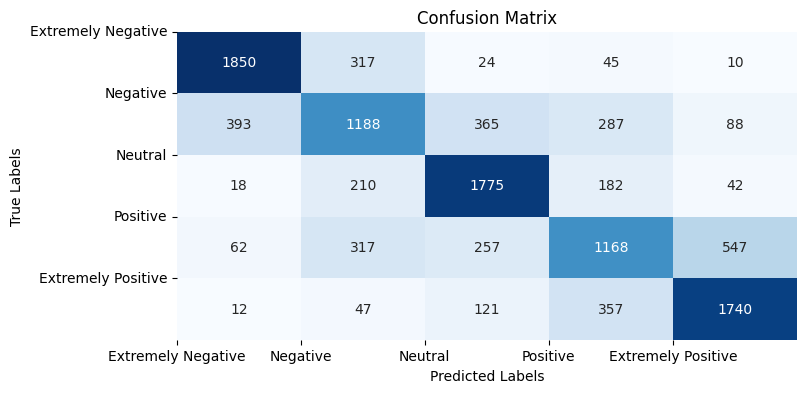

In [98]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0]
}
# Create GridSearchCV object
grid_search_lr = GridSearchCV(model_lr, param_grid_lr, cv=5)

# Fit the GridSearchCV object to the training data
grid_search_lr.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search_lr.best_params_)

# Get the best model
best_model_lr = grid_search_lr.best_estimator_

# Make predictions using the best model
y_pred_lr_gs = best_model_lr.predict(X_test)

accuracy_lr_gs = round(accuracy_score(y_test, y_pred_lr_gs),2)

print("Accuracy :", accuracy_lr_gs)

# Checking the classification report
print("\n\nClassification report for Logistic Regression\n\n", classification_report(y_test, y_pred_lr_gs))

plot_confusion_matrix(y_test, y_pred_lr_gs)

###**Decision Tree**

In [99]:
# Create an instance of the DecisionTreeClassifier model
model_dt = DecisionTreeClassifier()

# Fit the model to the training data
model_dt.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = model_dt.predict(X_test)

# Calculate the accuracy of the model
accuracy_dt = round(accuracy_score(y_test, y_pred_dt),2)
print("Accuracy:", accuracy_dt)

Accuracy: 0.5600595342321835


###**Cross-Validation and Hyper parameter Tuning for Decision Tree Classifier Model**
#### Increasing the grid_param increases the accuracy but takes more time to train the model as the max_depth and split value increases.

Best hyperparameters:  {'max_depth': 55, 'min_samples_leaf': 16, 'min_samples_split': 230}
Accuracy : 0.51


Classification report for Decision Tree Classifier model

               precision    recall  f1-score   support

           0       0.64      0.63      0.64      2246
           1       0.39      0.28      0.32      2321
           2       0.46      0.77      0.58      2227
           3       0.43      0.31      0.36      2351
           4       0.63      0.61      0.62      2277

    accuracy                           0.51     11422
   macro avg       0.51      0.52      0.50     11422
weighted avg       0.51      0.51      0.50     11422



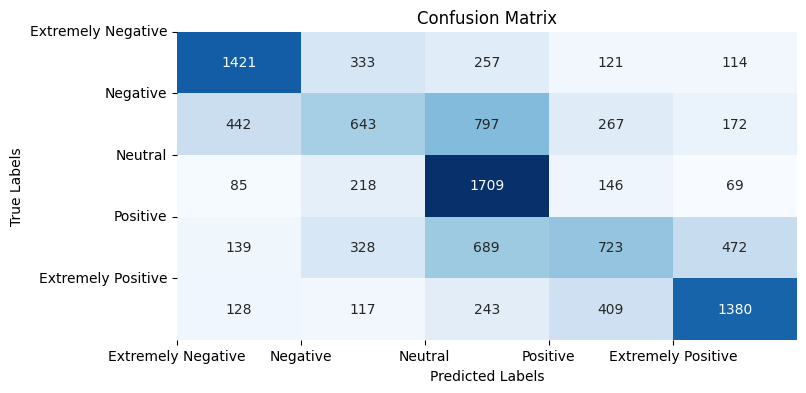

In [103]:
# Define the hyperparameters grid
param_grid = {
    'max_depth': [30, 40, 55],
    'min_samples_split': [20, 40, 230],
    'min_samples_leaf': [16, 32, 64]
}

# Create an instance of GridSearchCV
grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search_dt.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search_dt.best_params_)

# Use the best model for predictions
best_model_dt = grid_search_dt.best_estimator_
y_pred_dt_gs = best_model_dt.predict(X_test)

# Evaluation
accuracy_dt_gs = round(accuracy_score(y_test, y_pred_dt_gs),2)

print("Accuracy :", accuracy_dt_gs)

# Checking the classification report
print("\n\nClassification report for Decision Tree Classifier model\n\n", classification_report(y_test, y_pred_dt_gs))

plot_confusion_matrix(y_test, y_pred_dt_gs)

###**Support Vector Machines (SVM)**
####SVM works by finding an optimal hyperplane that separates the data points of different classes in a way that maximizes the margin between the classes. It maps the data points into a higher-dimensional space to find a hyperplane that can effectively classify the data. SVM is based on the concept of support vectors, which are the data points closest to the hyperplane.

In [107]:
# Create the SVM model
svm_model = SVC()

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_svm = svm_model.predict(X_test)

# Calculate the accuracy of the model
accuracy_svm = round(accuracy_score(y_test, y_pred_svm),2)
print("Accuracy:", accuracy_svm)

# Checking the classification report
print("\n\nClassification report for Support Vector Machine algorithm model\n\n", classification_report(y_test, y_pred_svm))

plot_confusion_matrix(y_test, y_pred_svm)

Accuracy: 0.73


###**Random Forest**

In [113]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model performance
accuracy_rf = round(accuracy_score(y_test, y_pred_rf),2)
print("Accuracy:", accuracy_rf)

# Checking the classification report
print("\n\nClassification report for Random Forest Classifier model\n\n", classification_report(y_test, y_pred_rf))

plot_confusion_matrix(y_test, y_pred_rf)

Accuracy: 0.6749255822097706


###**XGBoost Classifier Model**

In [116]:
# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier()

# Fit the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xg = xgb_classifier.predict(X_test)

# Evaluate the model performance
accuracy_xg = accuracy_score(y_test, y_pred_xg)
print("Accuracy:", accuracy_xg)

# Checking the classification report
print("\n\nClassification report for XGBoost Classifier model\n\n", classification_report(y_test, y_pred_xg))

plot_confusion_matrix(y_test, y_pred_xg)

KeyboardInterrupt: ignored